In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from skopt import BayesSearchCV, plots
from skopt.space import Real, Categorical, Integer

In [2]:
# raw data
url = "https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/ehr_preprocessed_seq_by_day_cat_embedding.pkl.zip"
with urllib.request.urlopen(url) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as zip_file:
        with zip_file.open("ehr_preprocessed_seq_by_day_cat_embedding.pkl", "r") as file:
            EHR = pd.read_pickle(file)
train = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/train.csv")
valid = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/valid.csv")
test = pd.read_csv("https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/raw_data/test.csv")
print(train.shape)
print(test.shape)
print(valid.shape)
print(len(EHR['feature_cols']))

(55941, 13)
(17933, 12)
(13598, 13)
171


In [3]:
# combined data
# load processed data
train_median = pd.read_csv('../data_processing/train/train_valid_mean_mode.csv')
train_latest = pd.read_csv('../data_processing/train/train_valid_latest.csv')
train_dispers = pd.read_csv('../data_processing/train/train_valid_entropy_std.csv')
train_min = pd.read_csv('../data_processing/train/train_valid_min.csv')
train_max = pd.read_csv('../data_processing/train/train_valid_max.csv')
train_q1 = pd.read_csv('../data_processing/train/train_valid_q1.csv')
train_q3 = pd.read_csv('../data_processing/train/train_valid_q3.csv')
train_kurtosis = pd.read_csv('../data_processing/train/train_valid_kurtosis.csv')
train_skewness = pd.read_csv('../data_processing/train/train_valid_skewness.csv')
train_range = pd.read_csv('../data_processing/train/train_valid_range.csv')
train_iqr = pd.read_csv('../data_processing/train/train_valid_iqr.csv')
train_latest = train_latest.drop(train_latest.columns[0:13], axis=1)
train_dispers = train_dispers.drop(train_dispers.columns[0:13], axis=1)
train_min = train_min.drop(train_min.columns[0:13], axis=1)
train_max = train_max.drop(train_max.columns[0:13], axis=1)
train_q1 = train_q1.drop(train_q1.columns[0:13], axis=1)
train_q3 = train_q3.drop(train_q3.columns[0:13], axis=1)
train_kurtois = train_kurtosis.drop(train_kurtosis.columns[0:13], axis=1)
train_skewness = train_skewness.drop(train_skewness.columns[0:13], axis=1)
train_range = train_range.drop(train_range.columns[0:13], axis=1)
train_iqr = train_iqr.drop(train_iqr.columns[0:13], axis=1)
train = pd.concat([train_median, train_latest, train_dispers, train_min, train_max], axis=1)

# load processed data
test_median = pd.read_csv('../data_processing/test/test_mean_mode.csv')
test_latest = pd.read_csv('../data_processing/test/test_latest.csv')
test_dispers = pd.read_csv('../data_processing/test/test_entropy_std.csv')
test_min = pd.read_csv('../data_processing/test/test_min.csv')
test_max = pd.read_csv('../data_processing/test/test_max.csv')
test_q1 = pd.read_csv('../data_processing/test/test_q1.csv')
test_q3 = pd.read_csv('../data_processing/test/test_q3.csv')
test_kurtosis = pd.read_csv('../data_processing/test/test_kurtosis.csv')
test_skewness = pd.read_csv('../data_processing/test/test_skewness.csv')
test_range = pd.read_csv('../data_processing/test/test_range.csv')
test_iqr = pd.read_csv('../data_processing/test/test_iqr.csv')
test_latest = test_latest.drop(test_latest.columns[0:12], axis=1)
test_dispers = test_dispers.drop(test_dispers.columns[0:12], axis=1)
test_min = test_min.drop(test_min.columns[0:12], axis=1)
test_max = test_max.drop(test_max.columns[0:12], axis=1)
test_q1 = test_q1.drop(test_q1.columns[0:12], axis=1)
test_q3 = test_q3.drop(test_q3.columns[0:12], axis=1)
test_kurtosis = test_kurtosis.drop(test_kurtosis.columns[0:12], axis=1)
test_skewness = test_skewness.drop(test_skewness.columns[0:12], axis=1)
test_range = test_range.drop(test_range.columns[0:12], axis=1)
test_iqr = test_iqr.drop(test_iqr.columns[0:12], axis=1)
test = pd.concat([test_median, test_latest, test_dispers, test_min, test_max], axis=1)

In [4]:
# separate response and features
X_train = train.drop(train.columns[0:13], axis=1)
y_train = train["readmitted_within_30days"]
X_test = test.drop(test.columns[0:12], axis=1)

In [5]:
# column categories
cat_cols = [EHR['feature_cols'][i] for i in EHR['cat_idxs']]
icd_cols = EHR['icd_cols']
cat_cols.extend(icd_cols)
num_cols = list(set(EHR['feature_cols']) - set(cat_cols)) 
print(cat_cols)
print(num_cols)

['gender', 'ethnicity', 'Creatinine Blood', 'Sodium Blood', 'pO2 Blood', 'Basophils Other Body Fluid', 'Basophils Pleural', 'Lactate Blood', 'Anion Gap Blood', 'Eosinophils Joint Fluid', 'Hemoglobin Blood', 'Chloride Blood', 'Eosinophils Ascites', 'pH Urine', 'Calcium, Total Blood', 'Lymphocytes Ascites', 'Eosinophils Other Body Fluid', 'Eosinophils Blood', 'Lymphocytes Blood', 'Basophils Joint Fluid', 'Hematocrit Blood', 'Potassium Blood', 'H Blood', 'Monocytes Blood', 'Eosinophils Pleural', 'Troponin T Blood', 'Neutrophils Blood', 'Bicarbonate Blood', 'Basophils Blood', 'Glucose Blood', 'Basophils Ascites', 'pH Blood', 'Platelet Count Blood', 'Lymphocytes Other Body Fluid', 'Monocytes Ascites', 'Lymphocytes Joint Fluid', 'Lymphocytes Pleural', 'pCO2 Blood', 'Y90-Y99', 'G30-G32', 'O85-O92', 'C60-C63', 'F40-F48', 'M80-M85', 'R00-R09', 'J90-J94', 'A00-A09', 'E00-E07', 'F01-F09', 'F30-F39', 'H30-H36', 'D60-D64', 'N00-N08', 'F60-F69', 'I80-I89', 'I95-I99', 'N30-N39', 'K55-K64', 'F50-F59',

In [6]:
num_cols_latest = [f"{col}_latest" for col in num_cols]
num_cols_mean_mode = [f"{col}_mean_mode" for col in num_cols]
num_cols_entropy_std = [f"{col}_entropy_std" for col in num_cols]
num_cols_min = [f"{col}_min" for col in num_cols]
num_cols_max = [f"{col}_max" for col in num_cols]

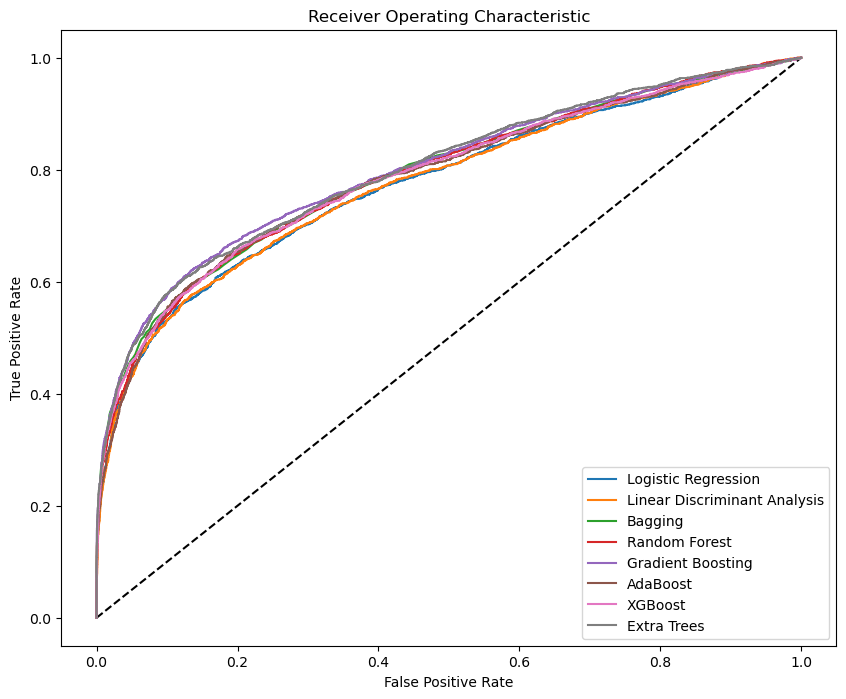

In [9]:
from cycler import cycler

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(10,8))
plt.gca().set_prop_cycle(cycler('color', colors))
plt.plot([0,1],[0,1],'k--')

# Compute ROC curve and ROC area for each model
for name, model in models:
    y_scores = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')
    fpr, tpr, _ = roc_curve(y_train, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=name)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(False)
plt.show()